# Analytics & Applications WS23/24 Project

The following notebook contains the applied steps of the CRISP-DM model on the
project excercise from "Analytics and Applications" by Prof. Ketter in the WS23/24 of University Cologne.

The following steps will be done in the specified order:
1. Data Preparation
2. Modeling 
3. Evaluation

## Imports & Dependencies

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

## Import Data

In [58]:
# ToDo: use path object
df = pd.read_csv("data/charging_sessions.csv")

## Data Exploration and Preparation

### Basic Data Exploration

In [59]:
print(df.head())

   Unnamed: 0                        id             connectionTime  \
0           0  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
1           1  5e23b149f9af8b5fe4b973d0  2020-01-02 13:36:50+00:00   
2           2  5e23b149f9af8b5fe4b973d1  2020-01-02 13:56:35+00:00   
3           3  5e23b149f9af8b5fe4b973d2  2020-01-02 13:59:58+00:00   
4           4  5e23b149f9af8b5fe4b973d3  2020-01-02 14:00:01+00:00   

              disconnectTime           doneChargingTime  kWhDelivered  \
0  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
1  2020-01-02 22:38:21+00:00  2020-01-02 20:18:05+00:00        33.097   
2  2020-01-03 00:39:22+00:00  2020-01-02 16:35:06+00:00         6.521   
3  2020-01-02 16:38:39+00:00  2020-01-02 15:18:45+00:00         2.355   
4  2020-01-02 22:08:40+00:00  2020-01-02 18:17:30+00:00        13.375   

                                sessionID  siteID  spaceID    stationID  \
0  1_1_179_810_2020-01-02 13:08:53.870034       1  AG-3F30  1-1-1

In [60]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        66450 non-null  int64  
 1   id                66450 non-null  object 
 2   connectionTime    66450 non-null  object 
 3   disconnectTime    66450 non-null  object 
 4   doneChargingTime  62362 non-null  object 
 5   kWhDelivered      66450 non-null  float64
 6   sessionID         66450 non-null  object 
 7   siteID            66450 non-null  int64  
 8   spaceID           66450 non-null  object 
 9   stationID         66450 non-null  object 
 10  timezone          66450 non-null  object 
 11  userID            49187 non-null  float64
 12  userInputs        49187 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 6.6+ MB
None


In [61]:
print(df.describe())

         Unnamed: 0  kWhDelivered        siteID        userID
count  66450.000000  66450.000000  66450.000000  49187.000000
mean    4726.102062     11.787916      1.472656   1800.494582
std     3568.025394     10.314789      0.499256   2617.548614
min        0.000000      0.501000      1.000000      1.000000
25%     1845.000000      5.097000      1.000000    431.000000
50%     3960.000000      9.140000      1.000000    818.000000
75%     7027.000000     14.183000      2.000000   1805.000000
max    15291.000000    108.797242      2.000000  19923.000000


### Set Data Types

In [69]:
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])

df['sessionID'] = df['sessionID'].astype(str)
df['siteID'] = df['siteID'].astype(str)
df['spaceID'] = df['spaceID'].astype(str)
df['stationID'] = df['stationID'].astype(str)
df['userID'] = df['userID'].astype(str)

In [63]:
# Rename first column
df = df.rename(columns={df.columns[0]: 'Index'})
df = df.set_index('Index')

In [77]:
# Session ID is a composite value of stationID and connectionTime, and therefor redundant
# Timezone contains only one value, and can therefor be considered meta-data
df = df.drop(['sessionID', 'timezone'], axis=1)

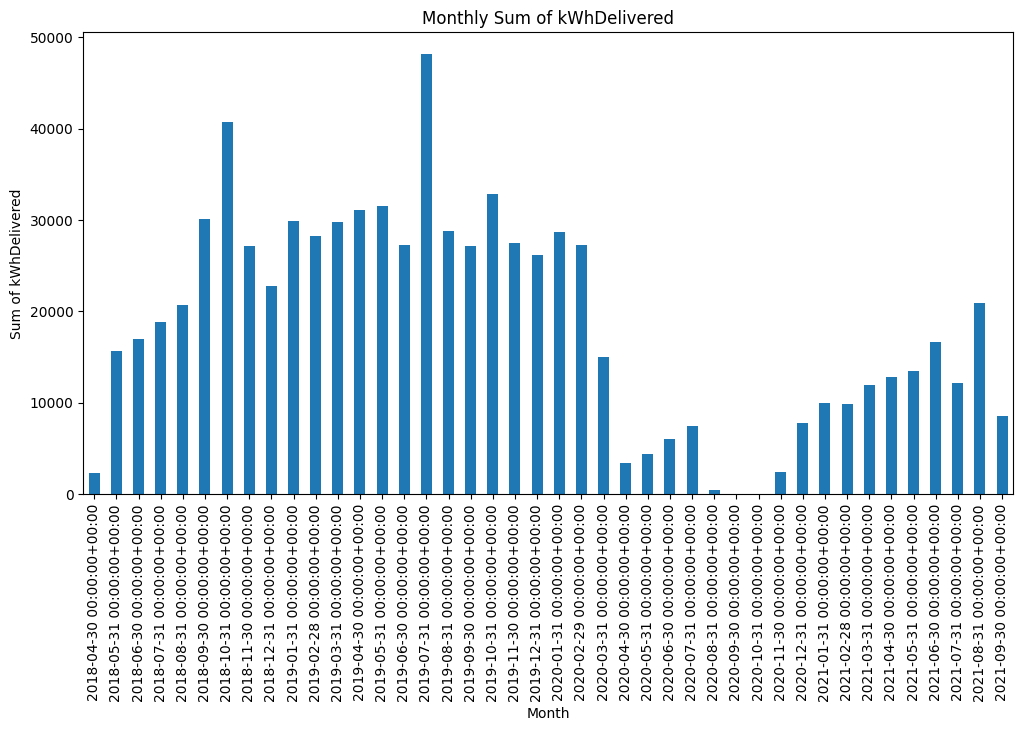

In [65]:
exploration = df.set_index('connectionTime')
exploration_monthly = exploration['kWhDelivered'].resample('M').sum()

# Plot the monthly sum
plt.figure(figsize=(12, 6))
exploration_monthly.plot(kind='bar')
plt.title('Monthly Sum of kWhDelivered')
plt.xlabel('Month')
plt.ylabel('Sum of kWhDelivered')
plt.show()

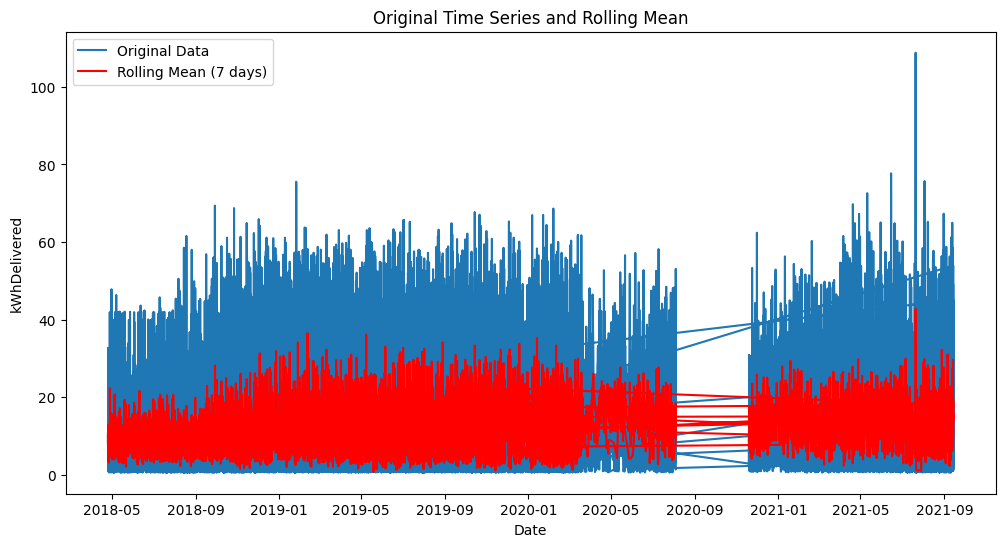

In [66]:
# Calculate rolling mean for a specified window (e.g., 7 days)
rolling_mean = exploration['kWhDelivered'].rolling(window=7).mean()

# Plot the original time series and the rolling mean
plt.figure(figsize=(12, 6))
plt.plot(exploration['kWhDelivered'], label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean (7 days)', color='red')
plt.title('Original Time Series and Rolling Mean')
plt.xlabel('Date')
plt.ylabel('kWhDelivered')
plt.legend()
plt.show()

### Handle Missing and Erronous Data

In [79]:
# TODO:
# - Fill Gap From 2020
# - Handle too long charges / unrealisitc charge volumes (remove / fill)
# - Handle Outliers for charging
# - Expand User Inputs column > drop user ID from user Inputs column, since its redundant

[{'WhPerMile': 250, 'kWhRequested': 25.0, 'milesRequested': 100, 'minutesAvailable': 463, 'modifiedAt': 'Thu, 02 Jan 2020 13:09:39 GMT', 'paymentRequired': True, 'requestedDeparture': 'Thu, 02 Jan 2020 20:51:54 GMT', 'userID': 194}]
